In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from skimage.io import imread
from skimage.transform import resize


In [2]:
# 1. Path to image dataset
data_path = 'breast augmented images'
img_size = (64, 64)

X = []
y = []
class_names = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
class_indices = {cls: i for i, cls in enumerate(class_names)}

for label in class_names:
    class_dir = os.path.join(data_path, label)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = imread(img_path)
            img_resized = resize(img, img_size, anti_aliasing=True)
            X.append(img_resized.flatten())
            y.append(class_indices[label])
        except Exception as e:
            print(f"Failed to process image {img_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} images with shape {X.shape[1:]} and {len(class_names)} classes.")


Loaded 12000 images with shape (12288,) and 3 classes.


In [8]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1. Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Apply PCA for dimensionality reduction
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# 3. Compute class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
weight_dict = {label: weight for label, weight in zip(np.unique(y_train), class_weights)}
sample_weights = np.array([weight_dict[label] for label in y_train])

# 4. Train Decision Tree classifier
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_pca, y_train, sample_weight=sample_weights)

# 5. Make predictions
pred_labels = clf.predict(X_val_pca)
pred_probs = clf.predict_proba(X_val_pca)

# 6. Calculate evaluation metrics
accuracy = accuracy_score(y_val, pred_labels)
f1 = f1_score(y_val, pred_labels, average='weighted')

try:
    # One-hot encode true labels for ROC AUC (required for multi-class)
    y_val_onehot = np.eye(len(np.unique(y_val)))[y_val]
    roc_auc = roc_auc_score(y_val_onehot, pred_probs, multi_class='ovr')
except Exception as e:
    roc_auc = None
    print(f"ROC AUC not available: {e}")

# 7. Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
if roc_auc is not None:
    print(f"ROC AUC Score: {roc_auc:.4f}")


Accuracy: 0.4263
F1 Score (weighted): 0.4260
ROC AUC Score: 0.5697


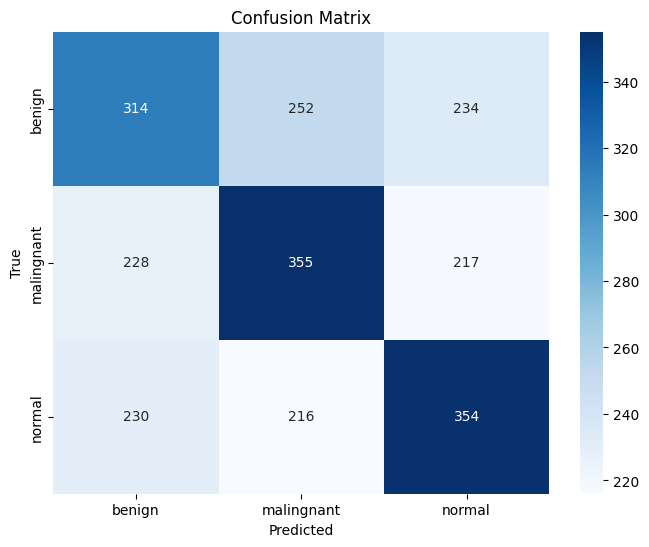

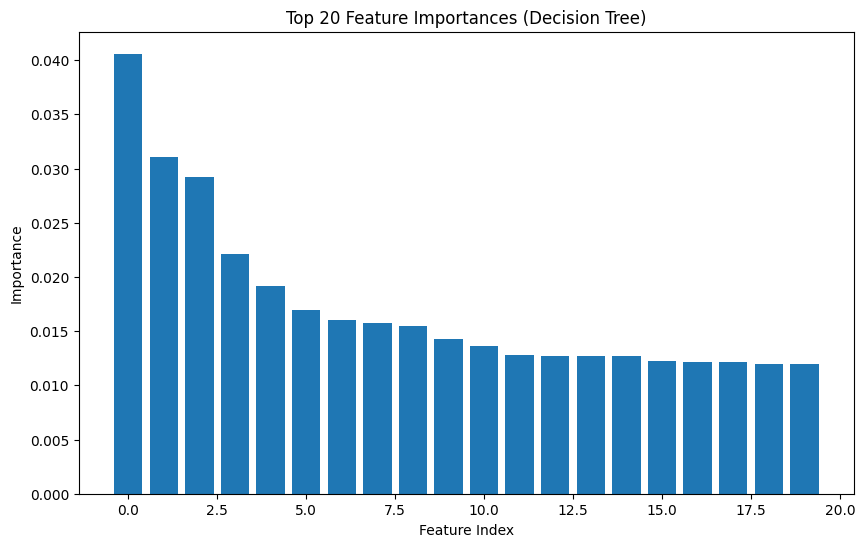

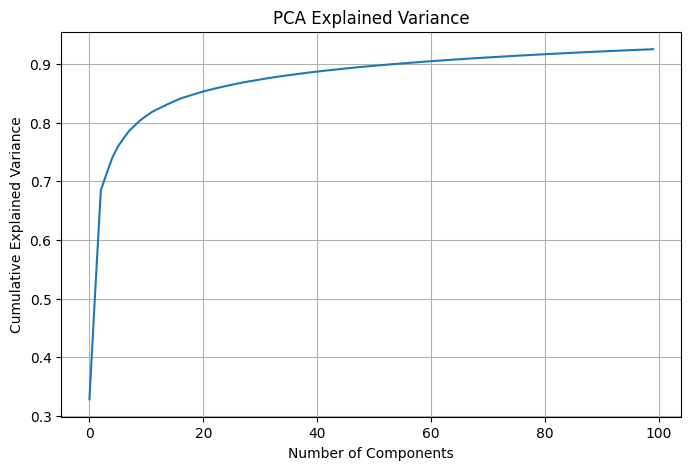

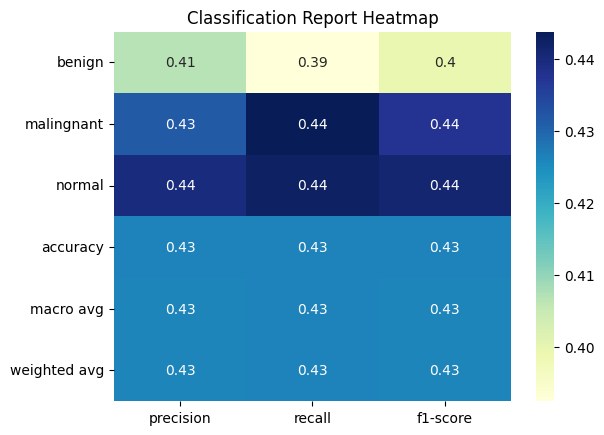

In [7]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, pred_labels), annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Feature importances (Decision Tree supports this)
importances = clf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices])
plt.title("Top 20 Feature Importances (Decision Tree)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# PCA explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Classification report heatmap
report = classification_report(y_val, pred_labels, output_dict=True, target_names=class_names)
report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()
